# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

3697762


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [20]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'Brain_MS_immune', 'MF3-msBrain_immune_redesign')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/designed_probes_idt_oPool.xlsx


## Input files:

In [21]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign'

In [22]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [23]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [24]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Load designed pd_dict

In [25]:
# candidate probes
import pickle
candidate_probe_filename = os.path.join(library_folder, '2023_8_29_candidate_probe.pkl')
                                   
print(candidate_probe_filename)
sel_pb_dict = pickle.load(open(candidate_probe_filename, 'rb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/2023_8_29_candidate_probe.pkl


In [26]:
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

In [27]:
sel_pb_dict = {_k:_v for _k,_v in sel_pb_dict.items() if _k in kept_gene_df.index}

In [28]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	148
Trac
	ENSMUST00000198398.5	507
Gramd3
	ENSMUST00000237355.2	1339
Ctsf
	ENSMUST00000119694.3	1181
Arhgap5
	ENSMUST00000219443.2	1313
Dach1
	ENSMUST00000069334.8	1450
Csf1r
	ENSMUST00000025523.13	2608
Tigit
	ENSMUST00000096065.6	449
Aoah
	ENSMUST00000021757.5	1507
Tnfrsf13c
	ENSMUST00000109535.3	781
Nfe2
	ENSMUST00000149111.8	1212
Il12rb2
	ENSMUST00000117441.8	1291
Zfp385a
	ENSMUST00000229373.2	1150
Dab2
	ENSMUST00000080880.12	2043
Cysltr1
	ENSMUST00000113480.2	1065
Trem2
	ENSMUST00000132340.2	2832
Fos
	ENSMUST00000140525.8	510
Jarid2
	ENSMUST00000173246.8	3181
Aicda
	ENSMUST00000043301.14	1259
Ralgapa1
	ENSMUST00000226244.2	3723
Atp8a1
	ENSMUST00000037380.15	3578
Rtcb
	ENSMUST00000001834.4	1268
Agtrap
	ENSMUST00000030865.9	2138
Pla2g15
	ENSMUST00000034377.8	1837
Btla
	ENSMUST00000102802.10	1081
Ifng
	ENSMUST00000068592.5	504
Zbtb18
	ENSMUST00000094276.5	1598
Lifr
	ENSMUST00000171588.2	4434
Cyth3
	ENSMUST00000116456.10	1918
Tbc1d9


In [29]:
print(len(sel_pb_dict))

368


# Load Codebook

In [30]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
#barcode_table.replace({'name':replace_dict}, inplace=True)
gene_ids = list(kept_gene_df.index)
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Trbc1,ENSMUST00000192856.6,0000000100100001001000
1,Trac,ENSMUST00000198398.5,0000100000000100100100
2,Ifng,ENSMUST00000068592.5,0000000000100000100110
3,Ly6g,ENSMUST00000190262.2,0100010100000000000001
4,Il17f,ENSMUST00000039046.10,0001110100000000000000
...,...,...,...
378,Blank-11,,1000000000000110000001
379,Blank-12,,0000000010110000000010
380,Blank-13,,0100100000000001001000
381,Blank-14,,0010000001001000100000


# Readouts

In [31]:
# load readouts
print(f"Loading readouts from file: {readout_savefile}")
readouts = pd.read_csv(readout_savefile)

Loading readouts from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/readouts.csv


In [32]:
# modify Stv into standard sequence
readout_seqs = pd.DataFrame(
    {'id':readouts['Name'], 'description':readouts['Name'], 'sequence':[_s[-20:] for _s in readouts['Sequence']]}
)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)

In [33]:
readout_seqs

,id,description,sequence,on-bit
0,Stv_3,Stv_3,CCAGATCGGACGATCATGGG,0
1,Stv_4,Stv_4,GCGCGATTGACCGTCTCGTT,1
2,Stv_5,Stv_5,CCGATGCGCAGCAATTCACT,2
3,Stv_6,Stv_6,GCCACGGTCCCGTTGAACTT,3
4,Stv_7,Stv_7,CGTCCAGCGCGTCAAACAGA,4
5,Stv_8,Stv_8,CCGTAACGAGCGTCCCTTGC,5
6,Stv_9,Stv_9,CCTGGCGTTGCGACGACTAA,6
7,Stv_10,Stv_10,CGGTCCACCGTTGCGCTTAC,7
8,Stv_11,Stv_11,CCAGGTCCGTCACGCAATTT,8
9,Stv_12,Stv_12,CGGAGCGTAGCGGAATCTGC,9


In [34]:
# Add the readout sequences. Here we randomly add 4 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readouts = 4

rs.add_readout_seqs_to_probes_random(sel_pb_dict, readout_seqs, barcode_table, 4, 
                                     n_threads=12,
                                     spacer='', gene_id_key='name', each_probe_1_on_bit=True) 
# if each_probe_1_on_bit set to be true, each probe will have 4 of the same readout sequence

Added readout sequences to 148 probes.
Added readout sequences to 510 probes.
Added readout sequences to 507 probes.
Added readout sequences to 770 probes.
Added readout sequences to 1081 probes.
Added readout sequences to 1454 probes.
Added readout sequences to 1035 probes.
Added readout sequences to 1507 probes.
Added readout sequences to 1263 probes.Added readout sequences to 504 probes.

Added readout sequences to 1688 probes.
Added readout sequences to 1464 probes.Added readout sequences to 1339 probes.

Added readout sequences to 781 probes.
Added readout sequences to 1124 probes.
Added readout sequences to 1181 probes.
Added readout sequences to 1598 probes.
Added readout sequences to 3972 probes.
Added readout sequences to 1212 probes.
Added readout sequences to 3181 probes.
Added readout sequences to 3609 probes.
Added readout sequences to 1870 probes.
Added readout sequences to 2939 probes.
Added readout sequences to 1313 probes.
Added readout sequences to 1652 probes.
Added 

Added readout sequences to 2072 probes.
Added readout sequences to 2924 probes.
Added readout sequences to 3850 probes.
Added readout sequences to 1320 probes.
Added readout sequences to 3553 probes.
Added readout sequences to 2820 probes.
Added readout sequences to 1150 probes.
Added readout sequences to 702 probes.
Added readout sequences to 3215 probes.
Added readout sequences to 699 probes.Added readout sequences to 1044 probes.

Added readout sequences to 3640 probes.
Added readout sequences to 2348 probes.
Added readout sequences to 5394 probes.
Added readout sequences to 4298 probes.
Added readout sequences to 3780 probes.
Added readout sequences to 1981 probes.
Added readout sequences to 1472 probes.
Added readout sequences to 2502 probes.
Added readout sequences to 1838 probes.
Added readout sequences to 849 probes.
Added readout sequences to 865 probes.
Added readout sequences to 701 probes.Added readout sequences to 2489 probes.

Added readout sequences to 2629 probes.
Added

In [35]:
%%time
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(sel_pb_dict, N_probes_per_transcript=96, 
                                   N_on_bits=4, N_threads=12)

Trbc1:ENSMUST00000192856.6: selected 96/148 probes with N_overlapping_bases=15491.0 and on-bit_coverage={10: 24, 18: 25, 15: 24, 7: 23}.
Fos:ENSMUST00000140525.8: selected 96/510 probes with N_overlapping_bases=3837.0 and on-bit_coverage={16: 24, 9: 24, 20: 23, 5: 25}.
Trac:ENSMUST00000198398.5: selected 96/507 probes with N_overlapping_bases=4194.0 and on-bit_coverage={16: 24, 19: 23, 4: 25, 13: 24}.
Gtf2h2:ENSMUST00000147229.8: selected 96/770 probes with N_overlapping_bases=2021.0 and on-bit_coverage={2: 24, 10: 24, 19: 24, 12: 24}.
Btla:ENSMUST00000102802.10: selected 96/1081 probes with N_overlapping_bases=587.0 and on-bit_coverage={3: 24, 11: 24, 6: 24, 14: 24}.
Pdha1:ENSMUST00000033662.9: selected 96/1035 probes with N_overlapping_bases=739.0 and on-bit_coverage={8: 25, 10: 24, 19: 24, 21: 23}.
Gimap8:ENSMUST00000203509.2: selected 96/1263 probes with N_overlapping_bases=665.0 and on-bit_coverage={8: 26, 3: 23, 4: 23, 21: 24}.
Dram1:ENSMUST00000156097.2: selected 96/1454 probes 

Lamp1:ENSMUST00000033824.8: selected 96/1056 probes with N_overlapping_bases=1257.0 and on-bit_coverage={8: 24, 3: 24, 12: 24, 7: 24}.
Il27:ENSMUST00000058429.6: selected 96/555 probes with N_overlapping_bases=3295.0 and on-bit_coverage={19: 23, 11: 24, 20: 24, 12: 25}.
Ahr:ENSMUST00000116436.9: selected 96/2308 probes with N_overlapping_bases=36.0 and on-bit_coverage={8: 26, 4: 25, 20: 22, 7: 23}.
Siglecg:ENSMUST00000124502.8: selected 96/1861 probes with N_overlapping_bases=147.0 and on-bit_coverage={8: 24, 0: 24, 21: 24, 7: 24}.
Abcg3:ENSMUST00000031239.13: selected 96/1142 probes with N_overlapping_bases=528.0 and on-bit_coverage={1: 25, 2: 23, 12: 21, 13: 27}.
Trem2:ENSMUST00000132340.2: selected 96/2832 probes with N_overlapping_bases=0.0 and on-bit_coverage={8: 24, 11: 24, 13: 24, 6: 24}.
Sesn1:ENSMUST00000099931.11: selected 96/1799 probes with N_overlapping_bases=218.0 and on-bit_coverage={13: 23, 2: 25, 10: 23, 5: 25}.
Il2:ENSMUST00000029275.6: selected 96/315 probes with N_o

Adam19:ENSMUST00000011400.8: selected 96/3657 probes with N_overlapping_bases=0.0 and on-bit_coverage={3: 24, 4: 24, 14: 24, 15: 24}.
Cnih4:ENSMUST00000134115.8: selected 96/1315 probes with N_overlapping_bases=478.0 and on-bit_coverage={8: 23, 17: 24, 3: 23, 15: 26}.
Lyve1:ENSMUST00000033050.5: selected 96/1323 probes with N_overlapping_bases=548.0 and on-bit_coverage={16: 25, 18: 24, 14: 23, 15: 24}.
Gas6:ENSMUST00000033828.7: selected 96/1411 probes with N_overlapping_bases=642.0 and on-bit_coverage={2: 24, 18: 24, 12: 24, 7: 24}.
Klhl2:ENSMUST00000034017.9: selected 96/1212 probes with N_overlapping_bases=691.0 and on-bit_coverage={16: 23, 12: 25, 6: 24, 15: 24}.
Il2ra:ENSMUST00000028111.6: selected 96/1783 probes with N_overlapping_bases=61.0 and on-bit_coverage={18: 25, 19: 25, 12: 23, 13: 23}.
Ralgps2:ENSMUST00000192343.6: selected 96/1879 probes with N_overlapping_bases=168.0 and on-bit_coverage={2: 21, 3: 26, 4: 24, 6: 25}.
Tmtc2:ENSMUST00000061506.9: selected 96/2490 probes w

Egln1:ENSMUST00000034469.7: selected 96/1617 probes with N_overlapping_bases=381.0 and on-bit_coverage={10: 25, 20: 22, 13: 26, 7: 23}.
Cd34:ENSMUST00000016638.8: selected 96/1321 probes with N_overlapping_bases=670.0 and on-bit_coverage={16: 24, 4: 24, 6: 24, 7: 24}.
Pfkfb4:ENSMUST00000198140.5: selected 96/2236 probes with N_overlapping_bases=78.0 and on-bit_coverage={9: 23, 10: 25, 3: 24, 4: 24}.
Adamts14:ENSMUST00000092486.11: selected 96/3272 probes with N_overlapping_bases=0.0 and on-bit_coverage={1: 24, 2: 24, 19: 24, 6: 24}.
F13a1:ENSMUST00000037491.11: selected 96/2026 probes with N_overlapping_bases=71.0 and on-bit_coverage={8: 22, 9: 25, 4: 24, 13: 25}.
Cd28:ENSMUST00000027165.3: selected 96/1486 probes with N_overlapping_bases=238.0 and on-bit_coverage={17: 24, 13: 24, 14: 24, 15: 24}.
Itpr1:ENSMUST00000203615.3: selected 96/5537 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 24, 9: 24, 10: 24, 6: 24}.
Csmd3:ENSMUST00000162830.8: selected 96/5813 probes with N_

Antxr2:ENSMUST00000031281.14: selected 96/2036 probes with N_overlapping_bases=0.0 and on-bit_coverage={17: 24, 2: 24, 5: 24, 9: 24}.
Rtl5:ENSMUST00000119076.9: selected 96/2502 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 25, 2: 24, 10: 23, 15: 24}.
Osbpl11:ENSMUST00000232100.2: selected 96/2182 probes with N_overlapping_bases=33.0 and on-bit_coverage={1: 25, 18: 23, 19: 24, 14: 24}.
Slc41a2:ENSMUST00000039956.6: selected 96/2284 probes with N_overlapping_bases=7.0 and on-bit_coverage={8: 24, 1: 24, 21: 23, 13: 25}.
Tnf:ENSMUST00000025263.15: selected 96/1050 probes with N_overlapping_bases=1450.0 and on-bit_coverage={16: 24, 11: 23, 12: 25, 7: 24}.
Alox5:ENSMUST00000167447.8: selected 96/2592 probes with N_overlapping_bases=68.0 and on-bit_coverage={8: 24, 20: 23, 12: 24, 5: 25}.
Cx3cr1:ENSMUST00000064165.5: selected 96/1947 probes with N_overlapping_bases=153.0 and on-bit_coverage={1: 23, 2: 23, 20: 25, 14: 25}.
Lyl1:ENSMUST00000037165.6: selected 96/1005 probes with 

Tmem86a:ENSMUST00000010451.8: selected 96/1123 probes with N_overlapping_bases=1166.0 and on-bit_coverage={1: 24, 2: 23, 3: 24, 5: 25}.
Soga1:ENSMUST00000069098.7: selected 96/4286 probes with N_overlapping_bases=0.0 and on-bit_coverage={8: 24, 2: 24, 11: 24, 12: 24}.
Pax5:ENSMUST00000014174.14: selected 96/4472 probes with N_overlapping_bases=0.0 and on-bit_coverage={1: 24, 18: 24, 11: 24, 9: 24}.
Xbp1:ENSMUST00000063084.16: selected 96/1070 probes with N_overlapping_bases=1055.0 and on-bit_coverage={0: 24, 3: 24, 7: 24, 15: 24}.
Nav2:ENSMUST00000064395.13: selected 96/6887 probes with N_overlapping_bases=0.0 and on-bit_coverage={1: 24, 13: 24, 20: 24, 5: 24}.
Tubgcp5:ENSMUST00000032627.5: selected 96/1489 probes with N_overlapping_bases=344.0 and on-bit_coverage={16: 25, 20: 24, 13: 23, 6: 24}.
Trim30b:ENSMUST00000145982.2: selected 96/1273 probes with N_overlapping_bases=274.0 and on-bit_coverage={1: 24, 10: 24, 5: 24, 6: 24}.
Ifitm10:ENSMUST00000059223.15: selected 96/1657 probes w

C1qbp:ENSMUST00000179291.2: selected 96/704 probes with N_overlapping_bases=2096.0 and on-bit_coverage={16: 24, 1: 25, 6: 24, 14: 23}.
Eldr:ENSMUST00000130392.9: selected 96/812 probes with N_overlapping_bases=1621.0 and on-bit_coverage={0: 23, 2: 25, 3: 25, 12: 23}.
BE692007:ENSMUST00000186500.2: selected 96/877 probes with N_overlapping_bases=848.0 and on-bit_coverage={0: 24, 1: 24, 3: 24, 21: 24}.
Abca13:ENSMUST00000042740.13: selected 96/6991 probes with N_overlapping_bases=0.0 and on-bit_coverage={18: 24, 11: 24, 4: 24, 14: 24}.
Rilpl2:ENSMUST00000031347.8: selected 96/749 probes with N_overlapping_bases=2250.0 and on-bit_coverage={0: 22, 17: 24, 11: 25, 5: 25}.
Itgae:ENSMUST00000102537.10: selected 96/2397 probes with N_overlapping_bases=29.0 and on-bit_coverage={0: 24, 18: 24, 19: 25, 20: 23}.
Tax1bp3:ENSMUST00000040687.12: selected 96/699 probes with N_overlapping_bases=2504.0 and on-bit_coverage={21: 23, 3: 23, 13: 25, 7: 25}.
CPU times: user 1.97 s, sys: 1.54 s, total: 3.51 s

# Primer

In [36]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [37]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [38]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A03_primer_2'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A10_primer_9'], index=None)

## Add the primer sequences

In [39]:
# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(sel_pb_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(sel_pb_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [40]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
1,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0


# Quality check

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Ctsf
	ENSMUST00000119694.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Arhgap5
	ENSMUST00000219443.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Dach1
	ENSMUST00000069334.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Csf1r
	ENSMUST00000025523.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Tigit
	ENSMUST00000096065.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Aoah
	ENSMUST00000021757.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Tnfrsf13c
	ENSMUST00000109535.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Nfe2
	ENSMUST00000149111.8: 96 

	ENSMUST00000086763.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Il12a
	ENSMUST00000107816.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Rorc
	ENSMUST00000197040.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Pbx1
	ENSMUST00000176540.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Vps13c
	ENSMUST00000077879.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Polr2e
	ENSMUST00000143438.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Pakap
	ENSMUST00000098066.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Bach2
	ENSMUST00000108180.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Myo1e
	ENSMUST00000034745.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Eomes
	ENSMUST00000111763.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  37.5.
Pdcd1
	ENSMUST00000027507.9: 96 / 9

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate 

	ENSMUST00000012612.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Tubgcp5
	ENSMUST00000032627.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Ece1
	ENSMUST00000102518.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Gga2
	ENSMUST00000033160.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Gna12
	ENSMUST00000000153.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Card11
	ENSMUST00000085786.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Tns3
	ENSMUST00000239111.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Spns3
	ENSMUST00000092940.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Fscn1
	ENSMUST00000031565.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Abca13
	ENSMUST00000042740.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  28.5.
Rilpl2
	ENSMUST00000031347.8:

Calculate OTs for 193/368 genes.
Calculate OTs for 194/368 genes.
Calculate OTs for 195/368 genes.
Calculate OTs for 196/368 genes.
Calculate OTs for 197/368 genes.
Calculate OTs for 198/368 genes.
Calculate OTs for 199/368 genes.
Calculate OTs for 200/368 genes.
Calculate OTs for 201/368 genes.
Calculate OTs for 202/368 genes.
Calculate OTs for 203/368 genes.
Calculate OTs for 204/368 genes.
Calculate OTs for 205/368 genes.
Calculate OTs for 206/368 genes.
Calculate OTs for 207/368 genes.
Calculate OTs for 208/368 genes.
Calculate OTs for 209/368 genes.
Calculate OTs for 210/368 genes.
Calculate OTs for 211/368 genes.
Calculate OTs for 212/368 genes.
Calculate OTs for 213/368 genes.
Calculate OTs for 214/368 genes.
Calculate OTs for 215/368 genes.
Calculate OTs for 216/368 genes.
Calculate OTs for 217/368 genes.
Calculate OTs for 218/368 genes.
Calculate OTs for 219/368 genes.
Calculate OTs for 220/368 genes.
Calculate OTs for 221/368 genes.
Calculate OTs for 222/368 genes.
Calculate 

	ENSMUST00000188845.7: 37 / 37 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Man2a2
	ENSMUST00000098346.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Hsd11b1
	ENSMUST00000016338.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Nxpe4
	ENSMUST00000216998.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Csf2
	ENSMUST00000019060.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Cd34
	ENSMUST00000016638.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Nrp2
	ENSMUST00000075144.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Arhgef10l
	ENSMUST00000105799.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Syngr1
	ENSMUST00000009727.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Alox5
	ENSMUST00000167447.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Eepd1
	ENSMUST00000040677.6:

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate OTs for 327/368 genes.
Calculate OTs for 328/368 genes.
Calculate OTs for 329/368 genes.
Calculate OTs for 330/368 genes.
Calculate OTs for 331/368 genes.
Calculate OTs for 332/368 genes.
Calculate OTs for 333/368 genes.
Calculate OTs for 334/368 genes.
Calculate OTs for 335/368 genes.
Calculate OTs for 336/368 genes.
Calculate OTs for 337/368 genes.
Calculate OTs for 338/368 genes.
Calculate OTs for 339/368 genes.
Calculate OTs for 340/368 genes.
Calculate OTs for 341/368 genes.
Calculate OTs for 342/368 genes.
Calculate OTs for 343/368 genes.
Calculate OTs for 344/368 genes.
Calculate 

	ENSMUST00000081728.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Prdm1
	ENSMUST00000039174.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ankrd33b
	ENSMUST00000123325.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Tmem219
	ENSMUST00000119781.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ptp4a3
	ENSMUST00000165541.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Man2a1
	ENSMUST00000086723.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
B3gnt5
	ENSMUST00000164397.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Pdha1
	ENSMUST00000033662.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Cpd
	ENSMUST00000021201.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Hmgn1
	ENSMUST00000050884.16: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Parp1
	ENSMUST00000027777.1

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 288/368 genes.
Calculate OTs for 289/368 genes.
Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate OTs for 327/368 genes.
Calculate OTs for 328/368 genes.
Calculate OTs for 329/368 genes.
Calculate OTs for 330/368 genes.
Calculate OTs for 331/368 genes.
Calculate OTs for 332/368 genes.
Calculate OTs for 333/368 genes.
Calculate OTs for 334/368 genes.
Calculate OTs for 335/368 genes.
Calculate OTs for 336/368 genes.
Calculate 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ctsf
	ENSMUST00000119694.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Arhgap5
	ENSMUST00000219443.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Dach1
	ENSMUST00000069334.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Csf1r
	ENSMUST00000025523.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Tigit
	ENSMUST00000096065.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Aoah
	ENSMUST00000021757.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Tnfrsf13c
	ENSMUST00000109535.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Nfe2
	ENSMUST00000149111.

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate 

	ENSMUST00000091112.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Hps4
	ENSMUST00000112359.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Siva1
	ENSMUST00000222729.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
P2ry13
	ENSMUST00000040622.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Cd36
	ENSMUST00000170051.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Adamts14
	ENSMUST00000092486.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Prf1
	ENSMUST00000219375.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Cd3g
	ENSMUST00000159019.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Cd3d
	ENSMUST00000034602.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Itpr1
	ENSMUST00000203615.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Cd3e
	ENSMUST00000102832.3: 96 / 96 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 287/368 genes.
Calculate OTs for 288/368 genes.
Calculate OTs for 289/368 genes.
Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 269/368 genes.
Calculate OTs for 270/368 genes.
Calculate OTs for 271/368 genes.
Calculate OTs for 272/368 genes.
Calculate OTs for 273/368 genes.
Calculate OTs for 274/368 genes.
Calculate OTs for 275/368 genes.
Calculate OTs for 276/368 genes.
Calculate OTs for 277/368 genes.
Calculate OTs for 278/368 genes.
Calculate OTs for 279/368 genes.
Calculate OTs for 280/368 genes.
Calculate OTs for 281/368 genes.
Calculate OTs for 282/368 genes.
Calculate OTs for 283/368 genes.
Calculate OTs for 284/368 genes.
Calculate OTs for 285/368 genes.
Calculate OTs for 286/368 genes.
Calculate OTs for 287/368 genes.
Calculate OTs for 288/368 genes.
Calculate OTs for 289/368 genes.
Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate 

	ENSMUST00000033050.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Rpgrip1
	ENSMUST00000111603.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Ero1b
	ENSMUST00000071973.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Fpr1
	ENSMUST00000061516.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Ccl22
	ENSMUST00000034231.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Rabgap1l
	ENSMUST00000028049.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Ncoa1
	ENSMUST00000085814.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Atp13a3
	ENSMUST00000100013.9: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Cxcr5
	ENSMUST00000215293.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Map4k1
	ENSMUST00000085835.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Egln1
	ENSMUST00000034469.7: 96 / 96 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 285/368 genes.
Calculate OTs for 286/368 genes.
Calculate OTs for 287/368 genes.
Calculate OTs for 288/368 genes.
Calculate OTs for 289/368 genes.
Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate OTs for 327/368 genes.
Calculate OTs for 328/368 genes.
Calculate OTs for 329/368 genes.
Calculate OTs for 330/368 genes.
Calculate OTs for 331/368 genes.
Calculate OTs for 332/368 genes.
Calculate OTs for 333/368 genes.
Calculate 

	ENSMUST00000008537.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Cd69
	ENSMUST00000032259.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Lacc1
	ENSMUST00000062789.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Itga2
	ENSMUST00000056117.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Mpp7
	ENSMUST00000115869.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Il23a
	ENSMUST00000026449.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Cd55
	ENSMUST00000140725.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Adam19
	ENSMUST00000011400.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Ciita
	ENSMUST00000230450.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Dip2b
	ENSMUST00000100203.10: 95 / 95 probe

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 354/368 genes.
Calculate OTs for 355/368 genes.
Calculate OTs for 356/368 genes.
Calculate OTs for 357/368 genes.
Calculate OTs for 358/368 genes.
Calculate OTs for 359/368 genes.
Calculate OTs for 360/368 genes.
Calculate OTs for 361/368 genes.
Calculate OTs for 362/368 genes.
Calculate OTs for 363/368 genes.
Calculate OTs for 364/368 genes.
Calculate OTs for 365/368 genes.
Calculate OTs for 366/368 genes.
Calculate OTs for 367/368 genes.
Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Ctsf
	ENSMUST00000119694.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Arhgap5
	ENSMUST00000219443.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Dach1
	ENSMUST00000069334.8: 96 / 96 probes passed the fi

	ENSMUST00000042780.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Gna15
	ENSMUST00000043709.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Slc41a2
	ENSMUST00000039956.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Lyl1
	ENSMUST00000037165.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Vars
	ENSMUST00000173584.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Klhl5
	ENSMUST00000101191.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Phlpp1
	ENSMUST00000061047.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Ppp1r9a
	ENSMUST00000164110.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Ptprc
	ENSMUST00000183301.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Antxr2
	ENSMUST00000031281.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Tnf
	ENSMUST00000025263.15: 95 / 95 pro

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate 

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 314/368 genes.
Calculate OTs for 315/368 genes.
Calculate OTs for 316/368 genes.
Calculate OTs for 317/368 genes.
Calculate OTs for 318/368 genes.
Calculate OTs for 319/368 genes.
Calculate OTs for 320/368 genes.
Calculate OTs for 321/368 genes.
Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate OTs for 327/368 genes.
Calculate OTs for 328/368 genes.
Calculate OTs for 329/368 genes.
Calculate OTs for 330/368 genes.
Calculate OTs for 331/368 genes.
Calculate OTs for 332/368 genes.
Calculate OTs for 333/368 genes.
Calculate OTs for 334/368 genes.
Calculate OTs for 335/368 genes.
Calculate OTs for 336/368 genes.
Calculate OTs for 337/368 genes.
Calculate OTs for 338/368 genes.
Calculate OTs for 339/368 genes.
Calculate OTs for 340/368 genes.
Calculate OTs for 341/368 genes.
Calculate OTs for 342/368 genes.
Calculate OTs for 343/368 genes.
Calculate 

	ENSMUST00000103134.4: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Rapgef5
	ENSMUST00000109691.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Ctnnd2
	ENSMUST00000081728.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Prdm1
	ENSMUST00000039174.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Ankrd33b
	ENSMUST00000123325.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Tmem219
	ENSMUST00000119781.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Ptp4a3
	ENSMUST00000165541.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Man2a1
	ENSMUST00000086723.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
B3gnt5
	ENSMUST00000164397.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Pdha1
	ENSMUST00000033662.9: 94 / 94 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Cpd
	ENSMUST00000021201.6: 96 / 9

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Gramd3
	ENSMUST00000237355.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ctsf
	ENSMUST00000119694.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Arhgap5
	ENSMUST00000219443.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Dach1
	ENSMUST00000069334.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Csf1r
	ENSMUST00000025523.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Tigit
	ENSMUST00000096065.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Aoah
	ENSMUST00000021757.5: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Tnfrsf13c
	ENSMUST00000109535.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Nfe2
	ENSMUST00000149111.8: 96 / 96

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 284/368 genes.
Calculate OTs for 285/368 genes.
Calculate OTs for 286/368 genes.
Calculate OTs for 287/368 genes.
Calculate OTs for 288/368 genes.
Calculate OTs for 289/368 genes.
Calculate OTs for 290/368 genes.
Calculate OTs for 291/368 genes.
Calculate OTs for 292/368 genes.
Calculate OTs for 293/368 genes.
Calculate OTs for 294/368 genes.
Calculate OTs for 295/368 genes.
Calculate OTs for 296/368 genes.
Calculate OTs for 297/368 genes.
Calculate OTs for 298/368 genes.
Calculate OTs for 299/368 genes.
Calculate OTs for 300/368 genes.
Calculate OTs for 301/368 genes.
Calculate OTs for 302/368 genes.
Calculate OTs for 303/368 genes.
Calculate OTs for 304/368 genes.
Calculate OTs for 305/368 genes.
Calculate OTs for 306/368 genes.
Calculate OTs for 307/368 genes.
Calculate OTs for 308/368 genes.
Calculate OTs for 309/368 genes.
Calculate OTs for 310/368 genes.
Calculate OTs for 311/368 genes.
Calculate OTs for 312/368 genes.
Calculate OTs for 313/368 genes.
Calculate 

	ENSMUST00000020161.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Il23r
	ENSMUST00000118364.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Prkca
	ENSMUST00000059595.11: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Klrb1c
	ENSMUST00000167691.9: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Relt
	ENSMUST00000008462.11: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Pax5
	ENSMUST00000014174.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Fchsd2
	ENSMUST00000098250.10: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Dynll2
	ENSMUST00000020775.9: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cd22
	ENSMUST00000186154.7: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Itprid2
	ENSMUST00000111785.9: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Abca1
	ENSMUST00000030010.4: 95 / 95 pr

Calculate OTs for 82/368 genes.
Calculate OTs for 83/368 genes.
Calculate OTs for 84/368 genes.
Calculate OTs for 85/368 genes.
Calculate OTs for 86/368 genes.
Calculate OTs for 87/368 genes.
Calculate OTs for 88/368 genes.
Calculate OTs for 89/368 genes.
Calculate OTs for 90/368 genes.
Calculate OTs for 91/368 genes.
Calculate OTs for 92/368 genes.
Calculate OTs for 93/368 genes.
Calculate OTs for 94/368 genes.
Calculate OTs for 95/368 genes.
Calculate OTs for 96/368 genes.
Calculate OTs for 97/368 genes.
Calculate OTs for 98/368 genes.
Calculate OTs for 99/368 genes.
Calculate OTs for 100/368 genes.
Calculate OTs for 101/368 genes.
Calculate OTs for 102/368 genes.
Calculate OTs for 103/368 genes.
Calculate OTs for 104/368 genes.
Calculate OTs for 105/368 genes.
Calculate OTs for 106/368 genes.
Calculate OTs for 107/368 genes.
Calculate OTs for 108/368 genes.
Calculate OTs for 109/368 genes.
Calculate OTs for 110/368 genes.
Calculate OTs for 111/368 genes.
Calculate OTs for 112/368 ge

	ENSMUST00000033828.7: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Ikzf3
	ENSMUST00000103141.4: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Cacna1e
	ENSMUST00000187541.7: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Spire1
	ENSMUST00000045105.13: 92 / 94 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Il27
	ENSMUST00000058429.6: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Tjp1
	ENSMUST00000032729.8: 93 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Dusp22
	ENSMUST00000095914.7: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Irf4
	ENSMUST00000021784.10: 93 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Dock5
	ENSMUST00000039135.6: 92 / 95 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Iqsec1
	ENSMUST00000101151.10: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Chsy1
	ENSMUST00000036372.8: 92 / 95 prob

Calculate OTs for 0/368 genes.
Calculate OTs for 1/368 genes.
Calculate OTs for 2/368 genes.
Calculate OTs for 3/368 genes.
Calculate OTs for 4/368 genes.
Calculate OTs for 5/368 genes.
Calculate OTs for 6/368 genes.
Calculate OTs for 7/368 genes.
Calculate OTs for 8/368 genes.
Calculate OTs for 9/368 genes.
Calculate OTs for 10/368 genes.
Calculate OTs for 11/368 genes.
Calculate OTs for 12/368 genes.
Calculate OTs for 13/368 genes.
Calculate OTs for 14/368 genes.
Calculate OTs for 15/368 genes.
Calculate OTs for 16/368 genes.
Calculate OTs for 17/368 genes.
Calculate OTs for 18/368 genes.
Calculate OTs for 19/368 genes.
Calculate OTs for 20/368 genes.
Calculate OTs for 21/368 genes.
Calculate OTs for 22/368 genes.
Calculate OTs for 23/368 genes.
Calculate OTs for 24/368 genes.
Calculate OTs for 25/368 genes.
Calculate OTs for 26/368 genes.
Calculate OTs for 27/368 genes.
Calculate OTs for 28/368 genes.
Calculate OTs for 29/368 genes.
Calculate OTs for 30/368 genes.
Calculate OTs for 

Calculate OTs for 322/368 genes.
Calculate OTs for 323/368 genes.
Calculate OTs for 324/368 genes.
Calculate OTs for 325/368 genes.
Calculate OTs for 326/368 genes.
Calculate OTs for 327/368 genes.
Calculate OTs for 328/368 genes.
Calculate OTs for 329/368 genes.
Calculate OTs for 330/368 genes.
Calculate OTs for 331/368 genes.
Calculate OTs for 332/368 genes.
Calculate OTs for 333/368 genes.
Calculate OTs for 334/368 genes.
Calculate OTs for 335/368 genes.
Calculate OTs for 336/368 genes.
Calculate OTs for 337/368 genes.
Calculate OTs for 338/368 genes.
Calculate OTs for 339/368 genes.
Calculate OTs for 340/368 genes.
Calculate OTs for 341/368 genes.
Calculate OTs for 342/368 genes.
Calculate OTs for 343/368 genes.
Calculate OTs for 344/368 genes.
Calculate OTs for 345/368 genes.
Calculate OTs for 346/368 genes.
Calculate OTs for 347/368 genes.
Calculate OTs for 348/368 genes.
Calculate OTs for 349/368 genes.
Calculate OTs for 350/368 genes.
Calculate OTs for 351/368 genes.
Calculate 

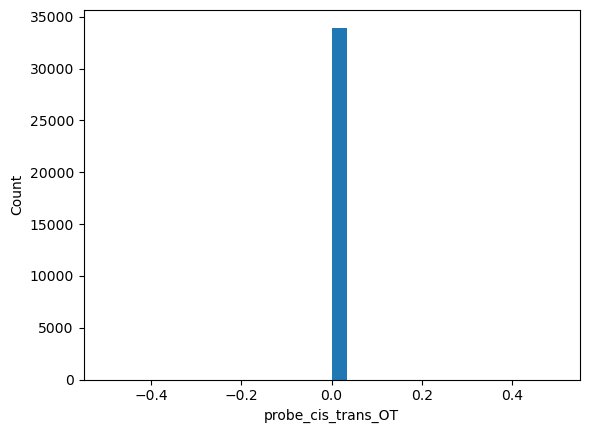

In [41]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(sel_pb_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(sel_pb_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(sel_pb_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(sel_pb_dict, 'probe_cis_trans_OT')

# Output

## default csv output

In [42]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(sel_pb_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(sel_pb_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/designed_probes.csv


In [43]:
len(df_all_probes)

33952

# IDT version output

# Twistbio output

In [44]:
import re, time
from Bio.Seq import reverse_complement

In [45]:
twist_final_probes = pd.DataFrame(
    {
        "name": df_all_probes['probe_names'].values,
        "sequence": df_all_probes['target_readout_primer_sequence_rc'].values,
        "library": ['MF3-msBrain_immune'] * len(df_all_probes),
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_merged_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/2023_8_29_twist_merged_probes.xlsx


## Write gene list

In [46]:
# Save the list of genes
final_gene_filename = os.path.join(library_folder, 'final_gene_info.csv')
# save
kept_gene_df.to_csv(final_gene_filename, index=1)

## Manual checks:

In [47]:
twist_final_probes.loc[0,'name']

'Idh3g_ENSMUST00000156299.8_shift:0_GC:46.6_Tm:52.4_specificity:1_isospecificity:0.5_Stv_28:Stv_28::Stv_28:Stv_28'

In [48]:
twist_final_probes.loc[0,'sequence'][20:40]

'GTCCTGTTCTTGTCGAGCGT'

In [49]:
twist_final_probes.loc[0,'sequence'][40:60]

'GTCCTGTTCTTGTCGAGCGT'

In [50]:
twist_final_probes.loc[0,'sequence'][60:90]

'GGACCTCTACAGGTCAAAACATTAAGCACC'

In [51]:
twist_final_probes.loc[0,'sequence'][:20]

'CCCGCAATGGCTGACAACCG'

In [52]:
twist_final_probes.loc[0,'sequence'][-20:]

'CGGAAACCATGCGGCAATCC'

In [53]:
# Quality check

In [ ]:
len(kept_gene_df)

In [57]:
kept_gene_df.loc['Il27']

Transcript              ENSMUST00000058429.6
Num_Candidate_Probes                     555
Group                              DC1 & DC2
Neutrophils-1                        0.05812
Mono/MACS-1                         0.019011
Mono/MACS-2                         0.189415
Neutrophils-2                       0.006024
NK cells                                 0.0
T-myeloid                           0.217105
Microglia-1                         0.004167
B cells-1                           0.016949
B cells-2                                0.0
Microglia-2                         0.057592
DC1 & DC2                           0.032895
pDC                                 0.008403
DC3                                 0.014085
Monocytes                           0.298507
Name: Il27, dtype: object

In [55]:
kept_gene_df

,Transcript,Num_Candidate_Probes,Group,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
Name,,,,,,,,,,,,,,,,,
Trbc1,ENSMUST00000192856.6,148,NK cells,0.010256,0.005703,0.044568,0.003012,0.204334,0.259868,0.004167,0.059322,0.005181,0.130890,0.046053,0.000000,0.098592,0.059701
Trac,ENSMUST00000198398.5,507,DC1 & DC2,0.032479,0.017110,0.072423,0.000000,0.151703,0.457237,0.000000,0.055085,0.020725,0.324607,0.177632,0.000000,0.126761,0.119403
Ifng,ENSMUST00000068592.5,504,B cells-1,0.022222,0.000000,0.089136,0.015060,0.835913,0.476974,0.000000,0.029661,0.000000,0.068063,0.092105,0.000000,0.000000,0.089552
Ly6g,ENSMUST00000190262.2,237,Neutrophils-2,4.283760,0.005703,0.044568,0.210843,0.089783,0.180921,0.012500,0.012712,0.015544,0.267016,0.026316,0.000000,0.647887,0.000000
Il17f,ENSMUST00000039046.10,531,DC1 & DC2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009868,0.000000,0.000000,0.000000,0.010471,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933421O10Rik,ENSMUST00000155691.2,1642,Mono/MACS-2,0.059829,0.114068,0.153203,0.039157,0.058824,0.203947,0.495833,0.076271,0.067358,0.701571,0.151316,0.033613,0.084507,0.179104
Lncpint,ENSMUST00000230209.3,1751,Neutrophils-2,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Gm15987,ENSMUST00000141700.2,640,pDC,0.058120,0.127376,1.125348,0.009036,0.046440,0.236842,0.004167,0.394068,0.176166,0.099476,0.815789,0.058824,0.140845,1.119403
